In [2]:
#!/usr/bin/env python3
import sys
sys.path.insert(0, "../src/")
import torch
from data.graph_transformer import *
from data.prepare_dataset import *
from plotter.plot_graph import *
from model.gnn import *
from model.train_model import *
from output.predict_model import *
import os
os.chdir("../")
import pbzlib
import networkx as nx

## Deep FP: training example

### Data Understanding



The data given is of the type of serializable protobuf messages. The author of the paper gives an example of script to read the data. 
The data is stored in hierarichal manner: 
- **Network object:** a description of the network, contains servers objects, flows objects
- **Server object:** a description of a server in the network, contains its parameters: id, rate and latency
- **Flow object:** a description of a flow in the network, contains its parameter: id, rate, burst, path and FPResult object
- **FPResult object:** contains the results of different explored combinations. It contains a FPCombination object for each combination
- **FPCombination object:** contains the delay bound achieved and the prolongations

For a better understanding, a proto file is added in the data folder

### Data preparation

The package src.data contains our data preparation modules. 

We do data preparation in two steps, namely (1) creating a networkx graph each given network and then (2) converting the graph object to a torch tensor to feed it to the network. The data preparation is an implementation of Algorithm 1 in the paper.

The first part of the algorithm creates a base graph i.e a graph without prolongation nodes.
This was done in graph_transformer module.


In [4]:
# the first network of the dataset
# network = next(pbzlib.open_pbz("data/raw/dataserv.ub.tum.de/dataset-evaluation.pbz"))
network = next(pbzlib.open_pbz("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/raw/dataserv.ub.tum.de/dataset-train.pbz"))
# network = next(pbzlib.open_pbz("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/src/extraction/source-sink.pbz"))
# network = next(pbzlib.open_pbz("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/src/output/output.pbz"))
# network

server {
  rate: 0.652298881523439
  latency: 0.5384246880613892
}
server {
  id: 1
  rate: 0.1981014874337499
  latency: 0.14038693814170045
}
server {
  id: 2
  rate: 0.5586898242041254
  latency: 0.4173048057735682
}
server {
  id: 3
  rate: 0.6704675095373693
  latency: 0.027387597179620027
}
server {
  id: 4
  rate: 0.8781174306508484
  latency: 0.20445225303549885
}
server {
  id: 5
  rate: 0.6852195043049478
  latency: 0.4191945092867837
}
server {
  id: 6
  rate: 0.9168613286559002
  latency: 0.0836230021541644
}
server {
  id: 7
  rate: 0.49305959663062193
  latency: 0.9499381437063239
}
flow {
  rate: 0.00031810534748519687
  burst: 0.968261581700407
  path: 5
  path: 4
  path: 3
  path: 2
  path: 1
  pmoo {
    delay_bound: 41.661718156913125
  }
  pmoofp {
    delay_bound: 41.661718156913125
    explored_combination {
      delay_bound: 41.70474947639015
      flows_prolongation {
        key: 2
        value: 1
      }
    }
    explored_combination {
      delay_bound: 41

In [7]:
i = 0
for network in pbzlib.open_pbz("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/raw/dataserv.ub.tum.de/dataset-train.pbz"):
    G, flows_paths = net2basegraph(network)
    i = i + 1
    if (i==1) :
        print(G)
        break

Graph with 25 nodes and 61 edges


Graph with 25 nodes and 61 edges


8

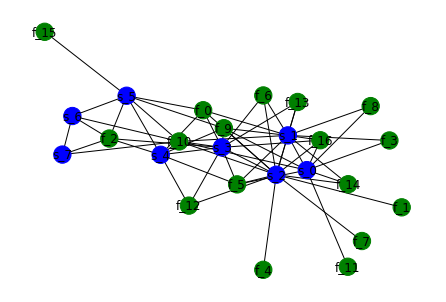

In [8]:
import re
plot_graph_network(G)
print(G)
len(network.server)

Now the graph created needs to be augmented to have the prolongation nodes. This is part 2 of Algorithm 1.

In [9]:
# We prolong the graph using the flow of interest 1
G, _, node_ids = prolong_graph(G, 3, flows_paths)
# the reason why the index is out of range is because that flow is not the flow of interest

Graph with 28 nodes and 67 edges


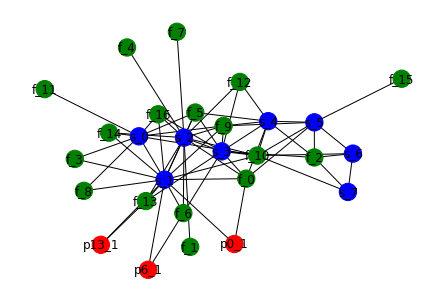

In [10]:
# visualizing the new graph
plot_graph_network(G)
print(G)

After creating a networkx graph from the network, we need to transform it to something that can be fed to a neural network. We convert it a torch tensor. This is done in prepare_dataset module, namely the method below

In [11]:
graph2torch(G, node_ids)

Data(x=[28, 10], edge_index=[2, 134], y=[28], mask=[28])

In [19]:
prepare_dataset("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/raw/dataserv.ub.tum.de/dataset-train.pbz", train= True, to_pickle= True )
prepare_dataset("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/data/raw/dataserv.ub.tum.de/dataset-evaluation.pbz", train= False, to_pickle= True )

([Data(x=[27, 10], edge_index=[2, 116], y=[27], mask=[27]),
  Data(x=[36, 10], edge_index=[2, 152], y=[36], mask=[36]),
  Data(x=[81, 10], edge_index=[2, 350], y=[81], mask=[81]),
  Data(x=[54, 10], edge_index=[2, 242], y=[54], mask=[54]),
  Data(x=[80, 10], edge_index=[2, 386], y=[80], mask=[80]),
  Data(x=[48, 10], edge_index=[2, 258], y=[48], mask=[48]),
  Data(x=[59, 10], edge_index=[2, 302], y=[59], mask=[59]),
  Data(x=[61, 10], edge_index=[2, 310], y=[61], mask=[61]),
  Data(x=[73, 10], edge_index=[2, 358], y=[73], mask=[73]),
  Data(x=[59, 10], edge_index=[2, 302], y=[59], mask=[59]),
  Data(x=[46, 10], edge_index=[2, 250], y=[46], mask=[46]),
  Data(x=[96, 10], edge_index=[2, 450], y=[96], mask=[96]),
  Data(x=[35, 10], edge_index=[2, 206], y=[35], mask=[35]),
  Data(x=[48, 10], edge_index=[2, 258], y=[48], mask=[48]),
  Data(x=[73, 10], edge_index=[2, 358], y=[73], mask=[73]),
  Data(x=[44, 10], edge_index=[2, 222], y=[44], mask=[44]),
  Data(x=[29, 10], edge_index=[2, 162], 

Preparing the dataset is doing all the steps on all the networks and flows of interest in the dataset.

### The model

The model is described in the paper. It can be used like follows.


In [14]:
os.chdir("../")
print(os.getcwd())
from model.gnn import *
model = GGNN(9, 96, unrolls=2)

/Users/wangweiran/Desktop/SemesterProject


You can train the model using the method train_model, it takes the path of the data pickle objects

In [15]:
train_graphs_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/train_graphs.pickle"
train_targets_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/train_targets.pickle"
test_graphs_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/test_graphs.pickle"
test_targets_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/test_targets.pickle"

# you can train the model using train_model method
model, losses_per_epoch = train_model(model= model, train_graphs= train_graphs_path, train_targets= train_targets_path,\
           test_graphs= test_graphs_path, test_targets= test_targets_path, learning_rate= 0.05, epochs= 30 )

  3%|▎         | 1/30 [24:44<11:57:31, 1484.52s/it]

  0 | loss=4.19e-01  | test_accuracy_deepfp= 0.6740366972477064 | test_accuracy_deepfp4= 0.6447706422018349


  7%|▋         | 2/30 [48:57<11:24:08, 1466.00s/it]

  1 | loss=2.98e-01  | test_accuracy_deepfp= 0.6618348623853211 | test_accuracy_deepfp4= 0.6738532110091743


 10%|█         | 3/30 [1:12:56<10:54:06, 1453.56s/it]

  2 | loss=2.84e-01  | test_accuracy_deepfp= 0.6240366972477064 | test_accuracy_deepfp4= 0.5192660550458715


 13%|█▎        | 4/30 [1:37:04<10:28:58, 1451.47s/it]

  3 | loss=3.19e-01  | test_accuracy_deepfp= 0.7034862385321101 | test_accuracy_deepfp4= 0.7273394495412844


 17%|█▋        | 5/30 [2:01:15<10:04:45, 1451.43s/it]

  4 | loss=3.01e-01  | test_accuracy_deepfp= 0.6993577981651377 | test_accuracy_deepfp4= 0.7128440366972477


 20%|██        | 6/30 [2:25:23<9:40:01, 1450.08s/it] 

  5 | loss=4.98e+01  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 23%|██▎       | 7/30 [2:49:17<9:13:53, 1444.93s/it]

  6 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 27%|██▋       | 8/30 [3:13:13<8:48:44, 1442.03s/it]

  7 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 30%|███       | 9/30 [3:37:05<8:23:33, 1438.73s/it]

  8 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 33%|███▎      | 10/30 [4:00:55<7:58:46, 1436.33s/it]

  9 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 37%|███▋      | 11/30 [4:24:42<7:33:53, 1433.37s/it]

 10 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 40%|████      | 12/30 [4:48:36<7:10:05, 1433.66s/it]

 11 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 43%|████▎     | 13/30 [5:12:36<6:46:42, 1435.47s/it]

 12 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 47%|████▋     | 14/30 [5:37:19<6:26:38, 1449.89s/it]

 13 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 50%|█████     | 15/30 [6:02:01<6:04:50, 1459.34s/it]

 14 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 53%|█████▎    | 16/30 [6:26:37<5:41:41, 1464.41s/it]

 15 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 57%|█████▋    | 17/30 [6:51:09<5:17:47, 1466.77s/it]

 16 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 60%|██████    | 18/30 [7:15:29<4:52:55, 1464.60s/it]

 17 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 63%|██████▎   | 19/30 [7:39:47<4:28:11, 1462.88s/it]

 18 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 67%|██████▋   | 20/30 [8:04:05<4:03:34, 1461.44s/it]

 19 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 70%|███████   | 21/30 [8:28:25<3:39:08, 1460.95s/it]

 20 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 73%|███████▎  | 22/30 [8:52:31<3:14:11, 1456.39s/it]

 21 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 77%|███████▋  | 23/30 [9:16:36<2:49:30, 1452.89s/it]

 22 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 80%|████████  | 24/30 [9:40:39<2:25:00, 1450.05s/it]

 23 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 83%|████████▎ | 25/30 [10:04:50<2:00:51, 1450.22s/it]

 24 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 87%|████████▋ | 26/30 [10:28:59<1:36:39, 1449.86s/it]

 25 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 90%|█████████ | 27/30 [10:53:07<1:12:28, 1449.47s/it]

 26 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 93%|█████████▎| 28/30 [11:17:22<48:21, 1450.87s/it]  

 27 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


 97%|█████████▋| 29/30 [11:41:36<24:11, 1451.88s/it]

 28 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


100%|██████████| 30/30 [12:06:04<00:00, 1452.14s/it]

 29 | loss=1.58e+02  | test_accuracy_deepfp= 0.05853211009174312 | test_accuracy_deepfp4= 0.05853211009174312


In [22]:
print(model)

GGNN(
  (init_layer): Sequential(
    (0): Linear(in_features=9, out_features=96, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (gru): GatedGraphConv(96, num_layers=1)
  (edge_attention): Sequential(
    (0): Linear(in_features=192, out_features=96, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=96, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (out): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=96, out_features=96, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (out1): Sequential(
    (0): Linear(in_features=96, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (out2): Sequential(
    (0): Linear(in_features=96, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [23]:
losses_per_epoch

[0.41902015605679405,
 0.2983543199503089,
 0.2838915908418618,
 0.31937974065498087,
 0.301469536702946,
 49.75727468949738,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384,
 157.52662024923384]

Save the model

In [24]:
import pickle
model_path = "/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/src/model/"
with open(model_path + "trained_model.pickle", "wb") as f:
    pickle.dump(model, f)

### Using the model for predicting new network

You can use the model to predict flow prolongations for a new network using predict_model module in the output package

In [41]:
print(os.getcwd())
os.chdir("DeepFP_gnn-main/src/output/")
print(os.getcwd())

/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project
/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/src/output


In [217]:
foi = 0
for base_network in pbzlib.open_pbz("/Users/wangweiran/Desktop/SemesterProject/EPFL_Network_Calculus_Semester_Project/DeepFP_gnn-main/src/extraction/source-sink.pbz"):
    prolongation_prediction = predict_network(network=base_network, foi_id=foi, model= model, output_file="stn_test" + str(foi) + ".pbz")
    foi = foi + 1
    if (foi == 2):
        break

In [219]:
predict_network(network=base_network, foi_id=1, model=model, output_file="stn_test1")

Data(x=[7, 10], edge_index=[2, 18], y=[7], mask=[7])

# That's all !


This notebook was created by Hadidane Karim (karim.hadidane@epfl.ch)  

And modified by Weiran Wang (weiran.wang@epfl.ch)